This notebook demonstrates a comprehensive sentiment analysis pipeline using both traditional 
machine learning approaches and modern transformer-based models (BERT). We'll compare different 
text preprocessing techniques, feature extraction methods, and model architectures.

In [176]:
import pandas as pd
import numpy as np
import re
import random

import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import unicodedata
import emoji
import contractions

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset
from evaluate import load as load_metric

In [57]:
# Download required NLTK data 
nltk.download('punkt') # Tokenization models 
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('stopwords') # Stopword list
nltk.download('punkt_tab') # Additional tokenization data

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\polina_sushko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\polina_sushko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\polina_sushko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\polina_sushko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [58]:
DATA_PATH_TRAIN = '../data/raw/train.csv'
DATA_PATH_TEST  = '../data/raw/test.csv'

# Helper functions

In [59]:
def clean_text(text):
    """
    Basic text cleaning:
    1. Convert emojis to text tokens
    2. Expand contractions
    3. Handle hashtags
    4. Remove HTML markup
    5. Normalize Unicode characters
    6. Convert to lowercase
    7. Remove non-word and non-whitespace characters
    8. Remove digits
    """   
    # Convert emojis to text tokens 
    text = emoji.demojize(text, delimiters = ("", ""))

    # Expand contractions
    text = contractions.fix(text)

    # Handle hashtags
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove HTML markup
    text = BeautifulSoup(text, "html.parser").get_text()

    # Normalize Unicode characters 
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii')
    
    # Converting to lowercase
    text = text.lower()
    
    # Removing non-word and non-whitespace characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Removing digits
    text = re.sub(r'\d', '', text)
    
    return text

In [60]:
def tokenize_text(text):
    """Tokenize text"""
    return word_tokenize(text)
    
def remove_stopwords(tokens):
    """Remove stopwords"""
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]
    
def stem_tokens(tokens):
    """Apply stemming"""
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(token) for token in tokens]
    
def lemmatize_tokens(tokens):
    """Apply lemmatization"""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

In [61]:
def preprocess_text(text, use_stemming, use_lemmatization):
    """Complete text preprocessing pipeline"""
    # Clean text
    cleaned = clean_text(text)
        
    # Tokenize
    tokens = tokenize_text(cleaned)
        
    # Remove stopwords
    tokens = remove_stopwords(tokens)
        
    # Apply stemming or lemmatization
    if use_stemming:
        tokens = stem_tokens(tokens)
    elif use_lemmatization:
        tokens = lemmatize_tokens(tokens)
        
    return ' '.join(tokens)

In [62]:
def predict_cls(model, X):
  return model.predict(X)

def evaluate_cls_model(model, X, y, name, return_metrics = False):
    y_pred = predict_cls(model, X)

    # Confusion Matrix
    cm         = confusion_matrix(y, y_pred)
    cm_counts  = confusion_matrix(y, y_pred)  # Raw counts for percentages
    total      = cm_counts.sum()
    cm_percent = (cm_counts / total * 100).round(2)  # Percentage for each cell

    # Calculate metrics
    accuracy  = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall    = recall_score(y, y_pred)
    f1        = f1_score(y, y_pred)

    # Create custom annotations with true values and percentages
    annot = [[f'{cm[i,j]}\n({cm_percent[i,j]:.2f}%)' for j in range(cm.shape[1])] for i in range(cm.shape[0])]

    plt.figure(figsize = (10, 4))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot = annot, fmt = '', cmap = 'Blues', cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix \n{name}')

    # ROC Curve and AUC
    if hasattr(model, 'predict_proba'):
      y_pred_proba         = model.predict_proba(X)[:, 1]
      fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
      roc_auc              = auc(fpr, tpr)

      plt.subplot(1, 2, 2)
      plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (area = {roc_auc:.2f})')
      plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'ROC Curve for {name}')
      plt.legend(loc = "lower right")
    else:
        plt.text(0.5, 0.5, 'ROC curve not available\nfor this model', 
                ha='center', va='center', fontsize=12)
        plt.title(f'ROC Curve\n{name}')
    plt.show()

    print(f"\n{name} Results:")
    print("=" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if hasattr(model, 'predict_proba'):
        print(f"ROC-AUC:   {roc_auc:.4f}")

    # Full classification report
    print('\nClassification Report:\n', classification_report(y, y_pred))

    if return_metrics:
        metrics_dict = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc if hasattr(model, 'predict_proba') else None
        }
        return metrics_dict

In [63]:
def evaluate_bert(trainer, dataset, label_encoder, name = "BERT (Validation)"):
    """
    Prints confusion-matrix, ROC, metrics for a Hugging Face Trainer model.
    """
    pred_out   = trainer.predict(dataset)
    logits     = pred_out.predictions                 
    y_true     = pred_out.label_ids                   
    y_pred     = np.argmax(logits, axis = 1)

    y_proba = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]

    cm          = confusion_matrix(y_true, y_pred)
    cm_percent  = (cm / cm.sum() * 100).round(2)
    annot       = [[f"{cm[i,j]}\n({cm_percent[i,j]:.2f}%)"
                    for j in range(cm.shape[1])] for i in range(cm.shape[0])]

    plt.figure(figsize=(10, 4))

    # Confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot = annot, fmt = '', cmap = 'Blues', cbar_kws = {'label': 'Count'})
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.title(f'Confusion Matrix\n{name}')

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc     = auc(fpr, tpr)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, lw = 2, label = f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve\n{name}'); plt.legend(loc = 'lower right')
    plt.tight_layout()
    plt.show()

    acc  = accuracy_score (y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score   (y_true, y_pred)
    f1   = f1_score       (y_true, y_pred)

    print(f"\n{name} Results:")
    print("="*50)
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec :.4f}")
    print(f"F1-Score:  {f1 :.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    print("\nClassification Report:\n",
          classification_report(y_true, y_pred,
                                target_names = label_encoder.classes_))

    return {"accuracy" : acc, 
            "precision" : prec, 
            "recall" : rec,
            "f1" : f1, 
            "roc_auc" : roc_auc}

# Read data

In [64]:
df_train = pd.read_csv(DATA_PATH_TRAIN, encoding = 'utf-8')
df_test  = pd.read_csv(DATA_PATH_TEST, encoding = 'utf-8')

In [65]:
print("\nFirst 5 rows of training data:")
display(df_train.head())
print("\nFirst 5 rows of test data:")
display(df_test.head())


First 5 rows of training data:


,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative



First 5 rows of test data:


,review,sentiment
0,"Yes, MTV there really is a way to market Daria...",negative
1,The story of the bride fair is an amusing and ...,negative
2,"A team varied between Scully and Mulder, two o...",positive
3,This was a popular movie probably because of t...,negative
4,This movie made me so angry!! Here I am thinki...,negative


# EDA

This section provides a comprehensive exploration of our sentiment analysis dataset. We'll examine the dataset structure, check for data quality issues like duplicates and missing values, analyze the distribution of sentiment labels, investigate text length patterns, and create visualizations to better understand the characteristics of positive and negative reviews.

In [66]:
print("Dataset shapes:")
print(f"Training set: {df_train.shape}")
print(f"Test set: {df_test.shape}")

Dataset shapes:
Training set: (40000, 2)
Test set: (10000, 2)


In [67]:
print("Dataset Info:")
df_train.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [68]:
print(f"Unique sentiment values: {df_train.sentiment.unique()}")

Unique sentiment values: ['positive' 'negative']


In [69]:
print("Sentiment distribution in training set:")
print(df_train.sentiment.value_counts())

print("\nSentiment distribution in test set:")
print(df_test.sentiment.value_counts())

Sentiment distribution in training set:
sentiment
positive    20000
negative    20000
Name: count, dtype: int64

Sentiment distribution in test set:
sentiment
negative    5000
positive    5000
Name: count, dtype: int64


## Check for duplicates

In [70]:
duplicated_df_train = df_train[df_train.duplicated()]
duplicated_df_test  = df_test[df_test.duplicated()]
display(duplicated_df_train.shape, duplicated_df_train, duplicated_df_test.shape, duplicated_df_test)

(272, 2)

,review,sentiment
1700,There are plenty of comments already posted sa...,negative
2062,No one would ever question that director Leos ...,positive
2659,Well I guess I know the answer to that questio...,negative
3540,There's something frustrating about watching a...,negative
4176,Do we really need any more narcissistic garbag...,negative
...,...,...
39722,"Yep, this has got to be one of the lamest movi...",negative
39738,Inappropriate. The PG rating that this movie g...,negative
39803,"Les Visiteurs, the first movie about the medie...",negative
39926,This film is so bad and gets worse in every im...,negative


(13, 2)

,review,sentiment
1899,The scenes are fast-paced. the characters are ...,positive
2964,I've tried to reconcile why so many bad review...,positive
3068,What a clunker!<br /><br />It MUST have been m...,negative
3266,The daytime TV of films. Seldom have I felt so...,negative
4624,"Pretentious claptrap, updating Herman Melville...",negative
6026,"well, the writing was very sloppy, the directi...",negative
6990,"Hilarious, clean, light-hearted, and quote-wor...",positive
7524,What can I say? An excellent end to an excelle...,positive
8167,"What a shocker. For starters, I couldn't stand...",negative
8911,Since I am required to write minimum of 10 lin...,negative


There are some duplicates in train and test data, I'll delete them.

In [71]:
df_train = df_train.drop_duplicates()
df_test  = df_test.drop_duplicates()

In [72]:
df_train.shape, df_test.shape

((39728, 2), (9987, 2))

## Check missing values

In [73]:
print("Missing values in training set:")
print(df_train.isna().sum())

print("\nMissing values in test set:")
print(df_test.isna().sum())

Missing values in training set:
review       0
sentiment    0
dtype: int64

Missing values in test set:
review       0
sentiment    0
dtype: int64


There are no missing values in both data sets.

## Sentiment Distribution Analysis

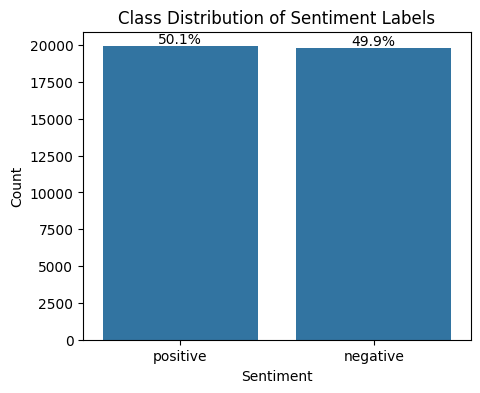

In [52]:
# Plotting the sentiment distribution
plt.figure(figsize = (5, 4))
ax = sns.countplot(x = 'sentiment', data = df_train, order = df_train['sentiment'].value_counts().index)
plt.title('Class Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')

total = len(df_train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage,
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha = 'center', va = 'bottom')
plt.show()

The dataset shows a balanced distribution between positive and negative sentiments.

In [ ]:
# Text Length Analysis
df_train['text_length'] = df_train['review'].apply(len)

print("Sentiment distribution:")
print(df_train['sentiment'].value_counts())

print("\nText length statistics:")
print(df_train['text_length'].describe())

Sentiment distribution:
sentiment
positive    19923
negative    19805
Name: count, dtype: int64

Text length statistics:
count    39728.000000
mean      1311.359469
std        988.798970
min         41.000000
25%        699.000000
50%        971.500000
75%       1596.000000
max      13704.000000
Name: text_length, dtype: float64


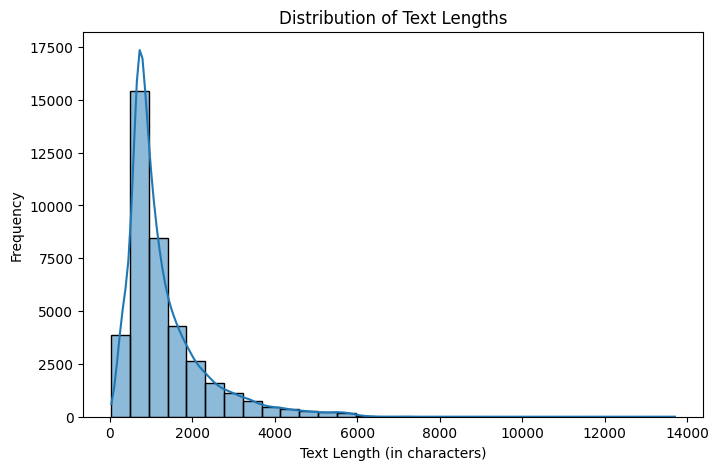

In [ ]:
# Plotting text length distribution
plt.figure(figsize = (8, 5))
sns.histplot(df_train['text_length'], bins = 30, kde = True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (in characters)')
plt.ylabel('Frequency')
plt.show()

Most texts fall within the range of 700 to 1500 characters, with the average length being 1311 characters.

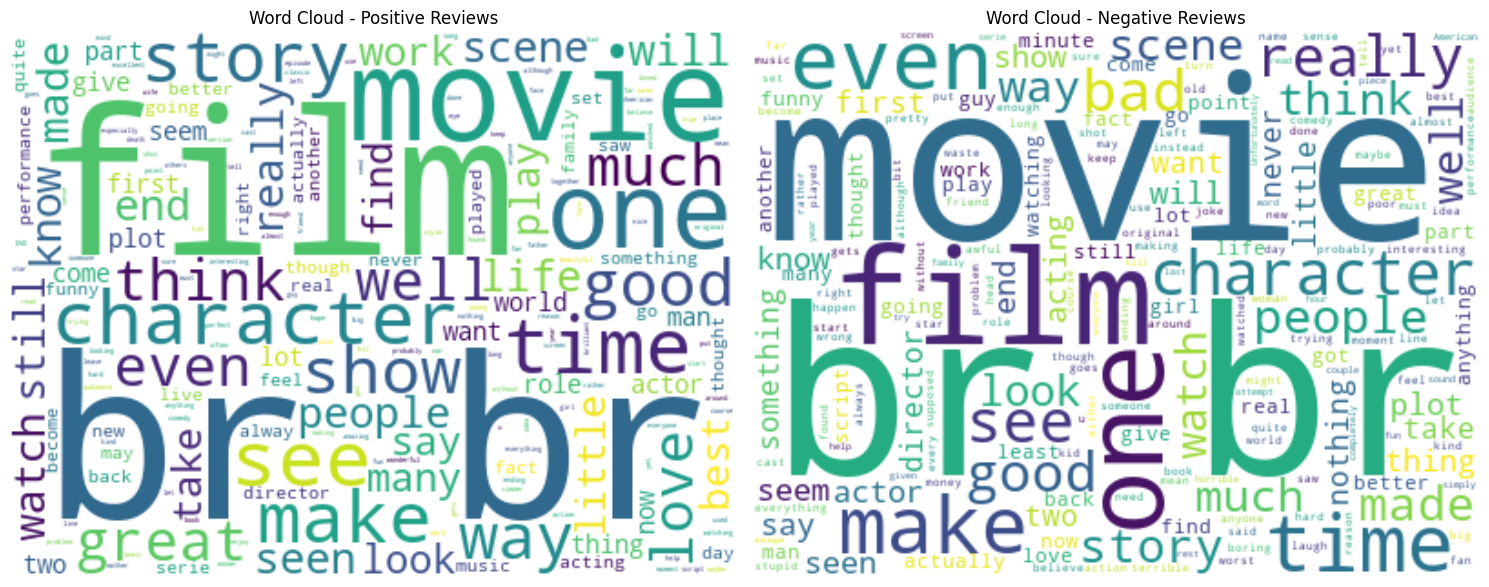

In [ ]:
# Word clouds
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
positive_reviews = df_train[df_train['sentiment'] == 'positive']['review']
positive_text = ' '.join(positive_reviews)
wordcloud_pos = WordCloud(width=400, height=300, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Word Cloud - Positive Reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
negative_reviews = df_test[df_test['sentiment'] == 'negative']['review']
negative_text = ' '.join(negative_reviews)
wordcloud_neg = WordCloud(width=400, height=300, background_color='white').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Word Cloud - Negative Reviews')
plt.axis('off')

plt.tight_layout()
plt.show()


**Summary of Key Insights:**

1. Sentiment Class Distribution:
    - Nearly equal distribution, indicating a balanced dataset for sentiment analysis.
2. Text Length Distribution:
    - The average length of texts is about 1311 characters.
    - Right-skewed distribution with most reviews between 699 and 1,596 characters.
    - Majority of reviews are concise, with fewer lengthy reviews.

In [ ]:
df_train.drop('text_length', axis = 1, inplace = True)

# Data Processing

This section focuses on preparing the text data for machine learning by applying various preprocessing techniques. We'll compare different text normalization methods (stemming vs lemmatization). We'll apply our preprocessing functions to the entire training dataset, creating two versions of the data: one with stemming and one with lemmatization. This allows us to compare the impact of different text normalization approaches on the final model performance and choose the most effective preprocessing strategy for our sentiment analysis task.

In [74]:
df_train

,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative
...,...,...
39995,It's the 1920s. And a man named Walt Disney wa...,positive
39996,"The first (and only) time I saw ""Shades"" was d...",negative
39997,This was such a waste of time. Danger: If you ...,negative
39998,this is by far the most pathetic movie Indian ...,negative


## Compare stemming vs lemmatization

Stemming is a simple and practical approach that involves cutting off the ends of words with the intention of obtaining the correct root form.
Lemmatization aims to remove inflectional endings only and to return the base or dictionary form of a word, which is known as 'lemma'. 

In [75]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

# Compare stemming vs lemmatization
print("Comparison of Stemming vs Lemmatization:")

# Test preprocessing on sample text
sample_text = df_train['review'].iloc[0]
print(f"\nOriginal text: {sample_text[:200]}...")

# Step by step preprocessing
cleaned_text = clean_text(sample_text)
print(f"\nCleaned text: {cleaned_text[:200]}...")

tokens = tokenize_text(cleaned_text)
print(f"\nTokenized (first 20): {tokens[:20]}")

tokens_no_stop = remove_stopwords(tokens)
print(f"\nWithout stopwords (first 20): {tokens_no_stop[:20]}")

stemmed_tokens = stem_tokens(tokens_no_stop)
print(f"\nStemmed (first 20): {stemmed_tokens[:20]}")

lemmatized_tokens = lemmatize_tokens(tokens_no_stop)
print(f"\nLemmatized (first 20): {lemmatized_tokens[:20]}")


Comparison of Stemming vs Lemmatization:

Original text: I caught this little gem totally by accident back in 1980 or '81. I was at a revival theatre to see two old silly sci-fi movies. The theatre was packed full and (with no warning) they showed a bunch o...

Cleaned text: i caught this little gem totally by accident back in  or  i was at a revival theatre to see two old silly scifi movies the theatre was packed full and with no warning they showed a bunch of scifi shor...

Tokenized (first 20): ['i', 'caught', 'this', 'little', 'gem', 'totally', 'by', 'accident', 'back', 'in', 'or', 'i', 'was', 'at', 'a', 'revival', 'theatre', 'to', 'see', 'two']

Without stopwords (first 20): ['caught', 'little', 'gem', 'totally', 'accident', 'back', 'revival', 'theatre', 'see', 'two', 'old', 'silly', 'scifi', 'movies', 'theatre', 'packed', 'full', 'warning', 'showed', 'bunch']

Stemmed (first 20): ['caught', 'littl', 'gem', 'total', 'accid', 'back', 'reviv', 'theatr', 'see', 'two', 'old', 'silli',

**Key Observations**
1. **STEMMING EFFECTS:**
    - 'little' → 'littl' (over-stemmed, creates non-word)
    - 'totally' → 'total' (correctly removes suffix)
    - 'accident' → 'accid' (over-stemmed, loses meaning)
    - 'silly' → 'silli' (incorrect stem)
    - 'movies' → 'movi' (over-stemmed)
    - 'warning' → 'warn' (correctly removes suffix)

2. **LEMMATIZATION EFFECTS:**
    - 'little' → 'little' (preserved, correct word)
    - 'totally' → 'totally' (preserved, adverb form)
    - 'accident' → 'accident' (preserved, correct word)
    - 'silly' → 'silly' (preserved, correct word)
    - 'movies' → 'movie' (correctly singularized)
    - 'warning' → 'warning' (preserved, correct word)

- **Stemming:** Faster processing, smaller vocabulary, but creates non-words
- **Lemmatization:** Preserves word meaning, maintains readability
- Stemmed tokens contain artificial roots like 'littl', 'accid', 'silli'
- Lemmatized tokens maintain real dictionary words

## Basic processing

In [135]:
# Create copies for different preprocessing approaches
train_stemmed    = df_train.copy()
train_lemmatized = df_train.copy()

train_stemmed['processed_review']    = [preprocess_text(text, use_stemming = True, use_lemmatization = False) for text in train_stemmed['review']]
train_lemmatized['processed_review'] = [preprocess_text(text, use_stemming = False, use_lemmatization = True) for text in train_lemmatized['review']]

In [77]:
# Compare processing results
print("\nComparison of preprocessing approaches:")
sample_idx = 11
print(f"Original: {df_train['review'].iloc[sample_idx][:500]}...")
print(f"Stemmed: {train_stemmed['processed_review'].iloc[sample_idx][:500]}...")
print(f"Lemmatized: {train_lemmatized['processed_review'].iloc[sample_idx][:500]}...")


Comparison of preprocessing approaches:
Original: Because 'cruel' would be the only word in existence to describe the intentions of these film makers. Where do you even begin? In a spout of b*tchiness, I'm going to start with the awful acting of nearly everybody in this movie. Scratch that. Nearly does not belong in that sentence. I can't think of even one character who was portrayed well. Although, in all fairness, it would be nearly impossible to portray these zero dimensional characters in a successful way. Still, the girl who played Katheri...
Stemmed: cruel would word exist describ intent film maker even begin spout btchiness go start aw act near everybodi movi scratch near belong sentenc think even one charact portray well although fair would near imposs portray zero dimension charact success way still girl play katherin whose name purpos includ pretend exist remain one worst actor ever seen eclips guy play sebastian stori god aw attempt mirror brillianc first one fail mani way 

In [78]:
display(train_stemmed.head(5), train_lemmatized.head(5))

,review,sentiment,processed_review
0,I caught this little gem totally by accident b...,positive,caught littl gem total accid back reviv theatr...
1,I can't believe that I let myself into this mo...,negative,believ let movi accomplish favor friend ask ea...
2,*spoiler alert!* it just gets to me the nerve ...,negative,spoiler alert get nerv peopl remak use term lo...
3,If there's one thing I've learnt from watching...,negative,one thing learnt watch georg romero creepshow ...
4,"I remember when this was in theaters, reviews ...",negative,rememb theater review said horribl well think ...


,review,sentiment,processed_review
0,I caught this little gem totally by accident b...,positive,caught little gem totally accident back reviva...
1,I can't believe that I let myself into this mo...,negative,believe let movie accomplish favor friend ask ...
2,*spoiler alert!* it just gets to me the nerve ...,negative,spoiler alert get nerve people remake use term...
3,If there's one thing I've learnt from watching...,negative,one thing learnt watching george romeros creep...
4,"I remember when this was in theaters, reviews ...",negative,remember theater review said horrible well thi...


- Lemmatized version maintains clearer semantic meaning, it remains more human-readable
- Stemmed text is harder to interpret due to truncated words
- Stemming reduces vocabulary more aggressively
- Lemmatization provides balanced vocabulary reduction
- Both remove stopwords and normalize case effectively

## Vectorization

This section converts our preprocessed text data into numerical representations that machine learning models can process. We'll explore two fundamental vectorization techniques: Bag of Words (BoW) and Term Frequency-Inverse Document Frequency (TF-IDF), applying both to our stemmed and lemmatized datasets to determine the optimal combination for sentiment analysis.

In [136]:
# Prepare data for vectorization
X_text_stemmed    = train_stemmed['processed_review']
X_text_lemmatized = train_lemmatized['processed_review']
y = df_train['sentiment']

# Encode labels
encoder   = LabelEncoder()
y_test = encoder.fit_transform(y)

# Split data for evaluation
X_train_stem, X_val_stem, y_train, y_val = train_test_split(X_text_stemmed, y_test, test_size = 0.2, random_state = 42, stratify = y_test)
X_train_lem, X_val_lem, _, _ = train_test_split(X_text_lemmatized, y_test, test_size = 0.2, random_state = 42, stratify = y_test)

### Bag of Words (BoW) vs Term Frequency-Inverse Document Frequency (TF-IDF)

The **Bag of Words** model represents text by converting it into a collection of words and their frequencies, completely disregarding grammar, word order, and context. Each document becomes a vector where each dimension corresponds to a unique word in the vocabulary, and the value represents how many times that word appears in the document. This approach treats text as an unordered collection of words, hence the term "bag" of words. While simple and computationally efficient, BoW captures the presence and frequency of important terms but loses sequential information and context that might be crucial for understanding sentiment nuances.

**TF-IDF** builds upon the BoW concept but addresses one of its major limitations by considering not just how frequently a word appears in a document, but also how rare or common that word is across the entire corpus. The Term Frequency component measures how often a word appears in a specific document, while the Inverse Document Frequency component reduces the weight of words that appear frequently across many documents. This approach helps identify words that are particularly characteristic of individual documents rather than common across the entire dataset. For sentiment analysis, TF-IDF can be particularly valuable because it emphasizes distinctive words that might be strong sentiment indicators while downweighting common words that appear in both positive and negative reviews.

In [137]:
count_vectorizer_stem = CountVectorizer(max_features = 5000, ngram_range = (1, 2))
count_vectorizer_lem  = CountVectorizer(max_features = 5000, ngram_range = (1, 2))

# Stemmed + Count
X_train_count_stem = count_vectorizer_stem.fit_transform(X_train_stem)
X_val_count_stem   = count_vectorizer_stem.transform(X_val_stem)

# Lemmatized + Count
X_train_count_lem = count_vectorizer_lem.fit_transform(X_train_lem)
X_val_count_lem   = count_vectorizer_lem.transform(X_val_lem)

In [81]:
print(f"Count (Stemmed) - Training shape: {X_train_count_stem.shape}")
print(f"Count (Stemmed) - Validation shape: {X_val_count_stem.shape}")
print(f"Count (Lemmatized) - Training shape: {X_train_count_lem.shape}")
print(f"Count (Lemmatized) - Validation shape: {X_val_count_lem.shape}")

Count (Stemmed) - Training shape: (31782, 5000)
Count (Stemmed) - Validation shape: (7946, 5000)
Count (Lemmatized) - Training shape: (31782, 5000)
Count (Lemmatized) - Validation shape: (7946, 5000)


In [138]:
tfidf_vectorizer_stem = TfidfVectorizer(max_features = 5000, ngram_range = (1, 2))
tfidf_vectorizer_lem  = TfidfVectorizer(max_features = 5000, ngram_range = (1, 2))

# Stemmed + TF-IDF
X_train_tfidf_stem = tfidf_vectorizer_stem.fit_transform(X_train_stem)
X_val_tfidf_stem   = tfidf_vectorizer_stem.transform(X_val_stem)

# Lemmatized + TF-IDF
X_train_tfidf_lem = tfidf_vectorizer_lem.fit_transform(X_train_lem)
X_val_tfidf_lem   = tfidf_vectorizer_lem.transform(X_val_lem)

In [83]:
print(f"TF-IDF (Stemmed) - Training shape: {X_train_tfidf_stem.shape}")
print(f"TF-IDF (Stemmed) - Validation shape: {X_val_tfidf_stem.shape}")
print(f"TF-IDF (Lemmatized) - Training shape: {X_train_tfidf_lem.shape}")
print(f"TF-IDF (Lemmatized) - Validation shape: {X_val_tfidf_lem.shape}")

TF-IDF (Stemmed) - Training shape: (31782, 5000)
TF-IDF (Stemmed) - Validation shape: (7946, 5000)
TF-IDF (Lemmatized) - Training shape: (31782, 5000)
TF-IDF (Lemmatized) - Validation shape: (7946, 5000)


### Dimensionality Reduction

In [98]:
def get_n_components(X, name):
    n_components_range = [10, 50, 100, 200, 500, 1000, 1500, 2000, 2500, 3000]
    explained_variances = []

    for n in n_components_range:
        svd = TruncatedSVD(n_components=n, random_state=42)
        svd.fit(X)  
        explained_variances.append(np.sum(svd.explained_variance_ratio_))

    # Plot cumulative explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(n_components_range, explained_variances, marker='o')
    plt.xlabel(f'Number of Components for {name}')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance vs. Number of Components')
    plt.grid(True)
    plt.show()

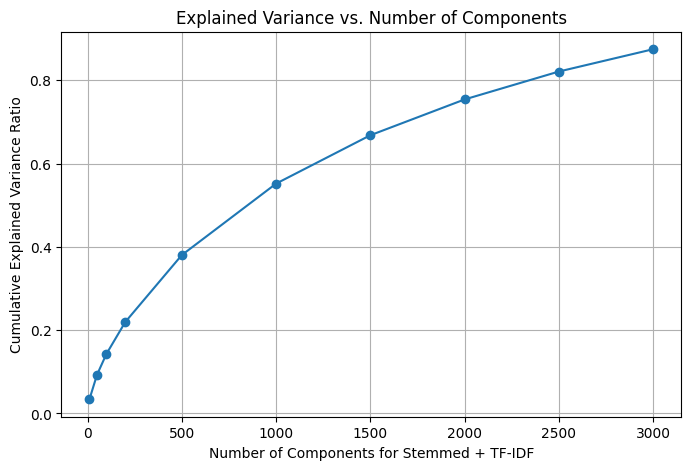

In [99]:
get_n_components(X_train_tfidf_stem, 'Stemmed + TF-IDF')

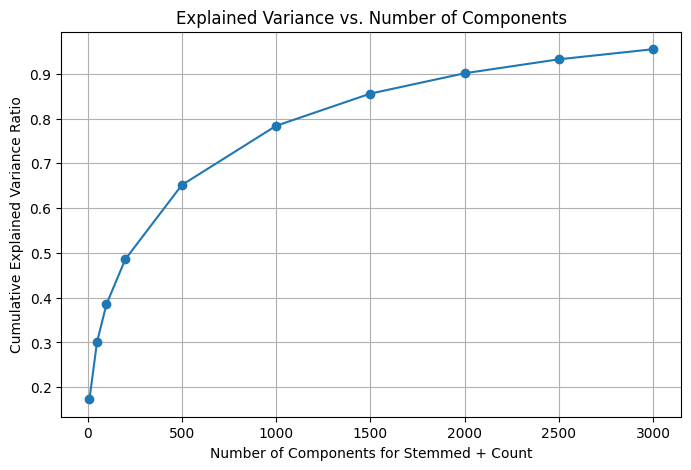

In [103]:
get_n_components(X_train_count_stem, 'Stemmed + Count')

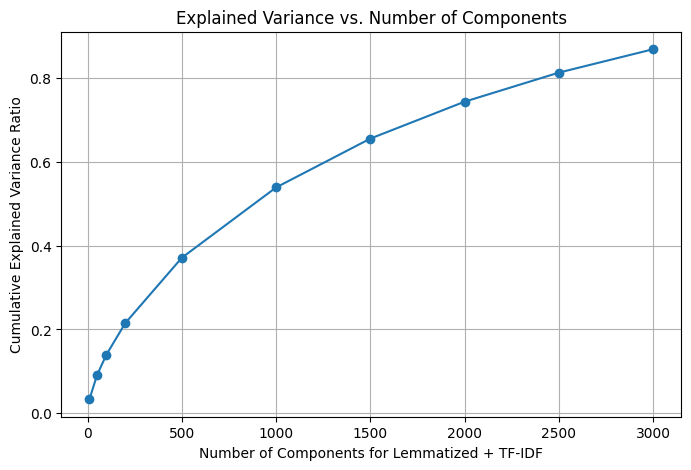

In [ ]:
get_n_components(X_train_tfidf_lem, 'Lemmatized + TF-IDF')

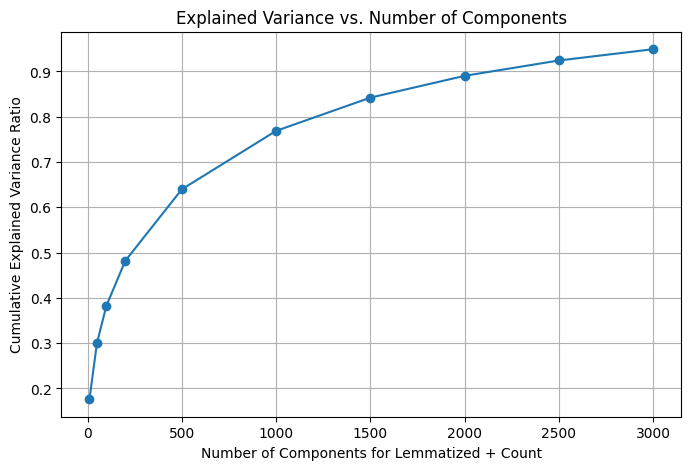

In [104]:
get_n_components(X_train_count_lem, 'Lemmatized + Count')

In [139]:
n_components = 3000

# Initialize TruncatedSVD
svd_stem_count = TruncatedSVD(n_components = n_components, random_state = 42)
svd_lem_count  = TruncatedSVD(n_components = n_components, random_state = 42)
svd_stem_tfidf = TruncatedSVD(n_components = n_components, random_state = 42)
svd_lem_tfidf  = TruncatedSVD(n_components = n_components, random_state = 42)

# Apply SVD to Stemm + TF-IDF
X_train_tfidf_stem_svd = svd_stem_tfidf.fit_transform(X_train_tfidf_stem)
X_val_tfidf_stem_svd   = svd_stem_tfidf.transform(X_val_tfidf_stem)

# Apply SVD to Lemmatized + TF-IDF
X_train_tfidf_lem_svd = svd_lem_tfidf.fit_transform(X_train_tfidf_lem)
X_val_tfidf_lem_svd   = svd_lem_tfidf.transform(X_val_tfidf_lem)

# Apply SVD to Stemm + Count
X_train_count_stem_svd = svd_stem_count.fit_transform(X_train_count_stem)
X_val_count_stem_svd   = svd_stem_count.transform(X_val_count_stem)

# Apply SVD to Lemmatized + Count
X_train_count_lem_svd = svd_lem_count.fit_transform(X_train_count_lem)
X_val_count_lem_svd   = svd_lem_count.transform(X_val_count_lem)

# Models training

This section implements and evaluates multiple machine learning models across different text preprocessing and vectorization combinations. We'll systematically compare model performance to identify the optimal approach for sentiment classification, followed by hyperparameter tuning to maximize the performance of our best models.

In [140]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state = 42, max_iter = 1000),
    'Random Forest': RandomForestClassifier(random_state = 42, n_estimators = 100),
    'Naive Bayes': MultinomialNB(),
    'XGBoost': XGBClassifier(random_state = 42, use_label_encoder = False, eval_metric = 'logloss')
}

# Data combinations to compare
data_combinations = {
    'Stemmed + Count': (X_train_count_stem, X_val_count_stem, X_train_count_stem_svd, X_val_count_stem_svd),  # (raw, svd)
    'Lemmatized + Count': (X_train_count_lem, X_val_count_lem, X_train_count_lem_svd, X_val_count_lem_svd),
    'Stemmed + TF-IDF': (X_train_tfidf_stem, X_val_tfidf_stem, X_train_tfidf_stem_svd, X_val_tfidf_stem_svd),
    'Lemmatized + TF-IDF': (X_train_tfidf_lem, X_val_tfidf_lem, X_train_tfidf_lem_svd, X_val_tfidf_lem_svd)
}

results = {}


==================== Stemmed + Count ====================

Training Logistic Regression...


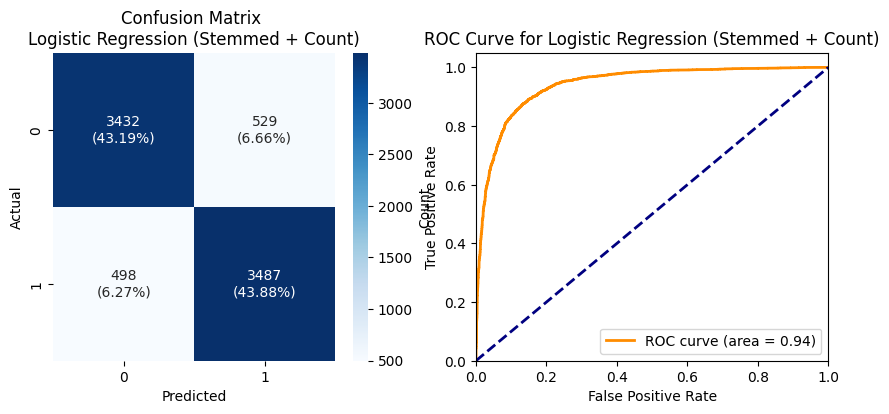


Logistic Regression (Stemmed + Count) Results:
Accuracy:  0.8708
Precision: 0.8683
Recall:    0.8750
F1-Score:  0.8716
ROC-AUC:   0.9401

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      3961
           1       0.87      0.88      0.87      3985

    accuracy                           0.87      7946
   macro avg       0.87      0.87      0.87      7946
weighted avg       0.87      0.87      0.87      7946


Training Random Forest...


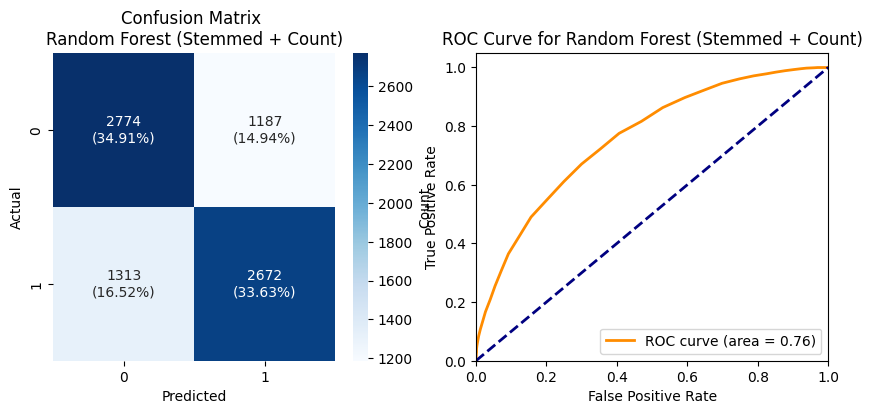


Random Forest (Stemmed + Count) Results:
Accuracy:  0.6854
Precision: 0.6924
Recall:    0.6705
F1-Score:  0.6813
ROC-AUC:   0.7576

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69      3961
           1       0.69      0.67      0.68      3985

    accuracy                           0.69      7946
   macro avg       0.69      0.69      0.69      7946
weighted avg       0.69      0.69      0.69      7946


Training Naive Bayes...


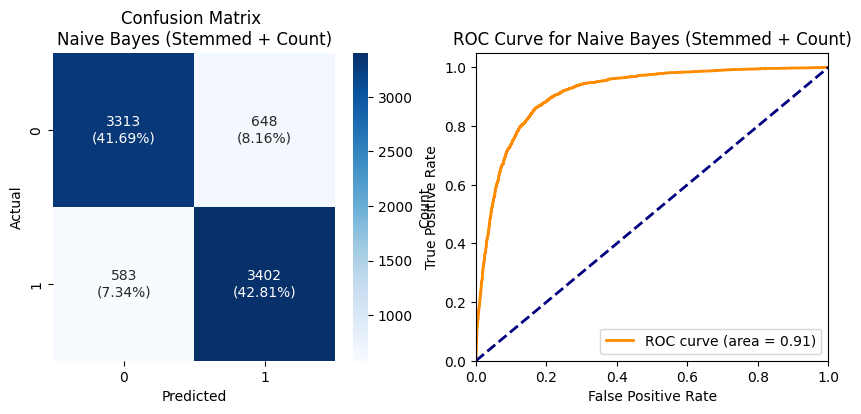


Naive Bayes (Stemmed + Count) Results:
Accuracy:  0.8451
Precision: 0.8400
Recall:    0.8537
F1-Score:  0.8468
ROC-AUC:   0.9124

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.84      3961
           1       0.84      0.85      0.85      3985

    accuracy                           0.85      7946
   macro avg       0.85      0.85      0.85      7946
weighted avg       0.85      0.85      0.85      7946


Training XGBoost...


c:\Users\polina_sushko\AppData\Local\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:49:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


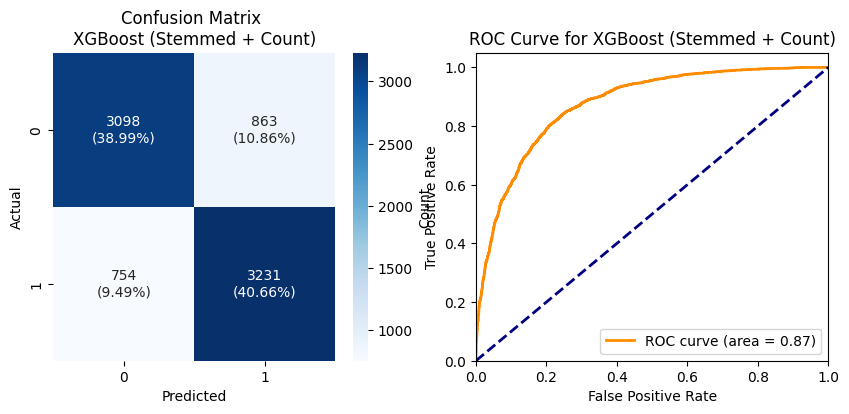


XGBoost (Stemmed + Count) Results:
Accuracy:  0.7965
Precision: 0.7892
Recall:    0.8108
F1-Score:  0.7999
ROC-AUC:   0.8741

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79      3961
           1       0.79      0.81      0.80      3985

    accuracy                           0.80      7946
   macro avg       0.80      0.80      0.80      7946
weighted avg       0.80      0.80      0.80      7946


==================== Lemmatized + Count ====================

Training Logistic Regression...


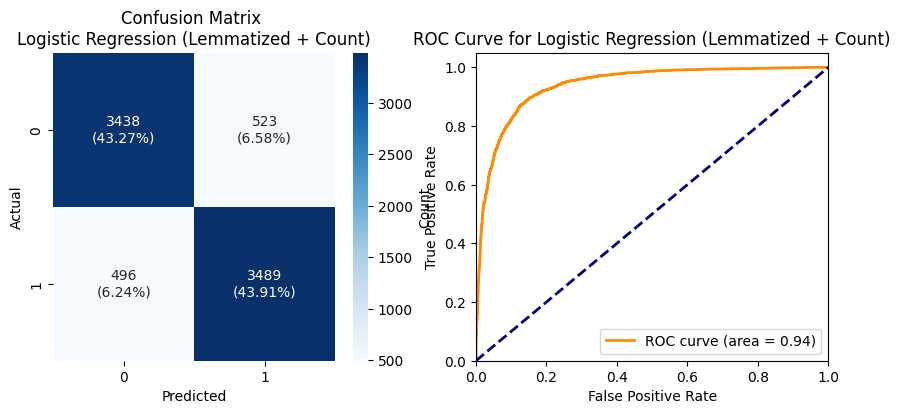


Logistic Regression (Lemmatized + Count) Results:
Accuracy:  0.8718
Precision: 0.8696
Recall:    0.8755
F1-Score:  0.8726
ROC-AUC:   0.9391

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      3961
           1       0.87      0.88      0.87      3985

    accuracy                           0.87      7946
   macro avg       0.87      0.87      0.87      7946
weighted avg       0.87      0.87      0.87      7946


Training Random Forest...


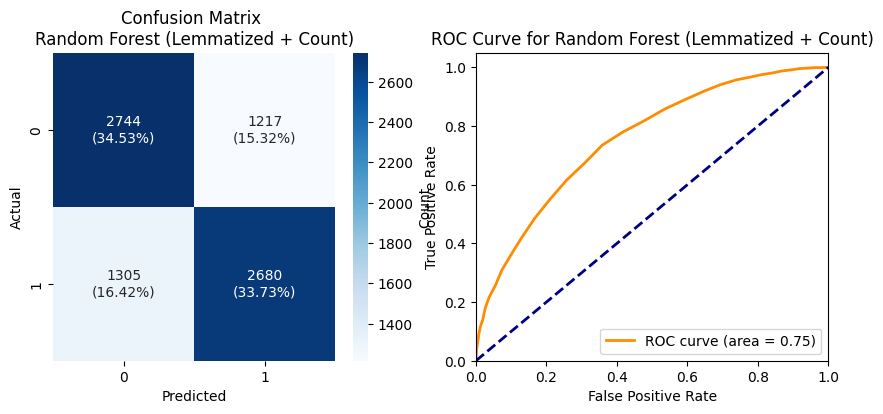


Random Forest (Lemmatized + Count) Results:
Accuracy:  0.6826
Precision: 0.6877
Recall:    0.6725
F1-Score:  0.6800
ROC-AUC:   0.7537

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.69      0.69      3961
           1       0.69      0.67      0.68      3985

    accuracy                           0.68      7946
   macro avg       0.68      0.68      0.68      7946
weighted avg       0.68      0.68      0.68      7946


Training Naive Bayes...


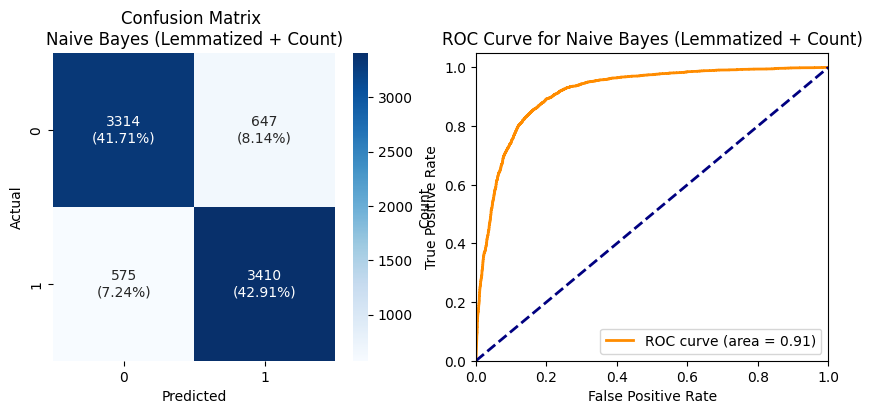


Naive Bayes (Lemmatized + Count) Results:
Accuracy:  0.8462
Precision: 0.8405
Recall:    0.8557
F1-Score:  0.8480
ROC-AUC:   0.9148

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.84      3961
           1       0.84      0.86      0.85      3985

    accuracy                           0.85      7946
   macro avg       0.85      0.85      0.85      7946
weighted avg       0.85      0.85      0.85      7946


Training XGBoost...


c:\Users\polina_sushko\AppData\Local\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:55:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


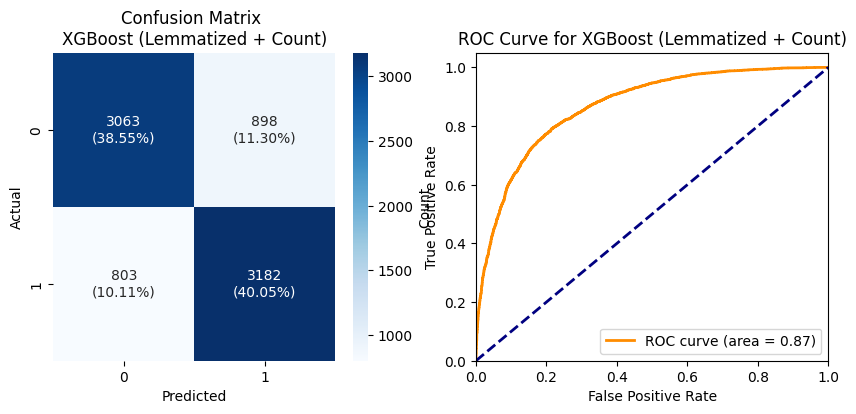


XGBoost (Lemmatized + Count) Results:
Accuracy:  0.7859
Precision: 0.7799
Recall:    0.7985
F1-Score:  0.7891
ROC-AUC:   0.8672

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.77      0.78      3961
           1       0.78      0.80      0.79      3985

    accuracy                           0.79      7946
   macro avg       0.79      0.79      0.79      7946
weighted avg       0.79      0.79      0.79      7946


==================== Stemmed + TF-IDF ====================

Training Logistic Regression...


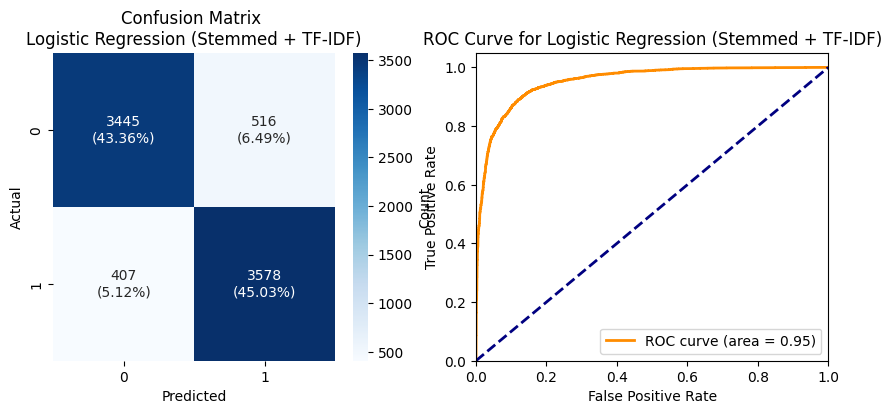


Logistic Regression (Stemmed + TF-IDF) Results:
Accuracy:  0.8838
Precision: 0.8740
Recall:    0.8979
F1-Score:  0.8858
ROC-AUC:   0.9523

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3961
           1       0.87      0.90      0.89      3985

    accuracy                           0.88      7946
   macro avg       0.88      0.88      0.88      7946
weighted avg       0.88      0.88      0.88      7946


Training Random Forest...


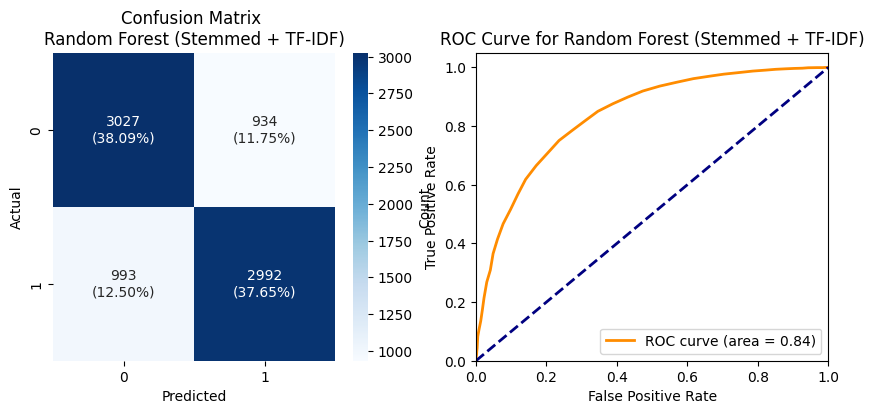


Random Forest (Stemmed + TF-IDF) Results:
Accuracy:  0.7575
Precision: 0.7621
Recall:    0.7508
F1-Score:  0.7564
ROC-AUC:   0.8363

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.76      0.76      3961
           1       0.76      0.75      0.76      3985

    accuracy                           0.76      7946
   macro avg       0.76      0.76      0.76      7946
weighted avg       0.76      0.76      0.76      7946


Training Naive Bayes...


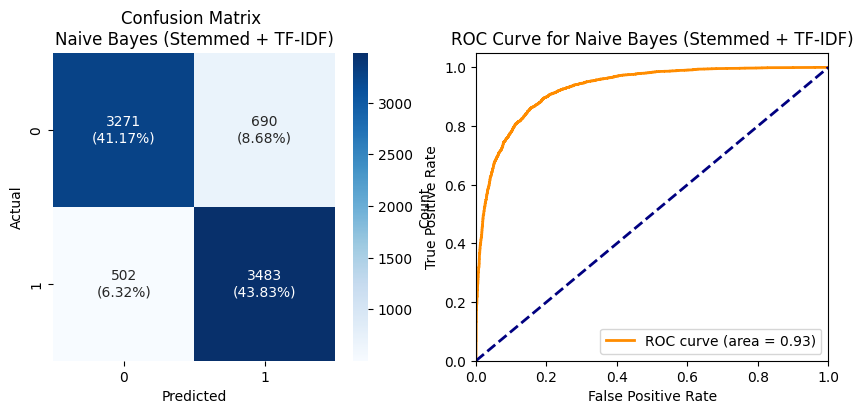


Naive Bayes (Stemmed + TF-IDF) Results:
Accuracy:  0.8500
Precision: 0.8347
Recall:    0.8740
F1-Score:  0.8539
ROC-AUC:   0.9294

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      3961
           1       0.83      0.87      0.85      3985

    accuracy                           0.85      7946
   macro avg       0.85      0.85      0.85      7946
weighted avg       0.85      0.85      0.85      7946


Training XGBoost...


c:\Users\polina_sushko\AppData\Local\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:02:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


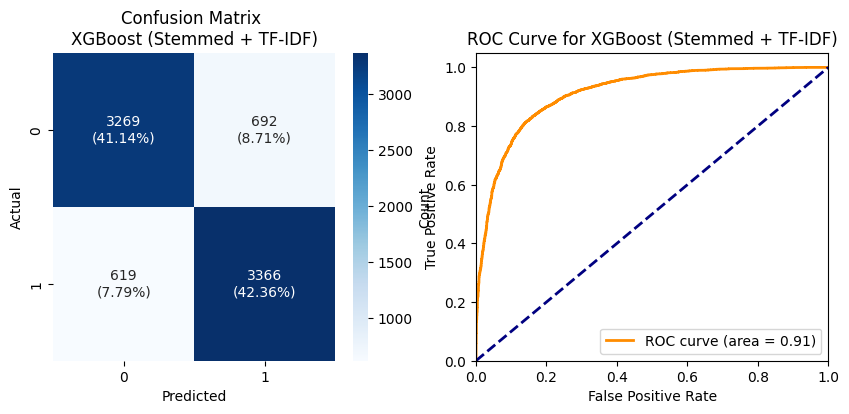


XGBoost (Stemmed + TF-IDF) Results:
Accuracy:  0.8350
Precision: 0.8295
Recall:    0.8447
F1-Score:  0.8370
ROC-AUC:   0.9124

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      3961
           1       0.83      0.84      0.84      3985

    accuracy                           0.84      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.84      0.83      7946


==================== Lemmatized + TF-IDF ====================

Training Logistic Regression...


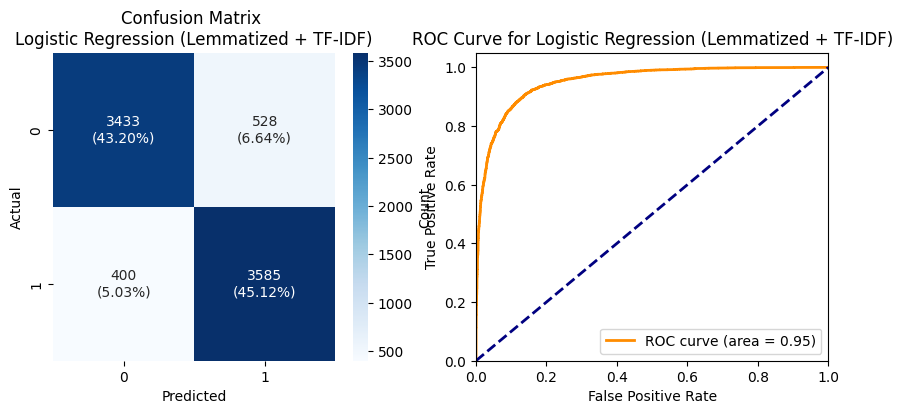


Logistic Regression (Lemmatized + TF-IDF) Results:
Accuracy:  0.8832
Precision: 0.8716
Recall:    0.8996
F1-Score:  0.8854
ROC-AUC:   0.9518

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      3961
           1       0.87      0.90      0.89      3985

    accuracy                           0.88      7946
   macro avg       0.88      0.88      0.88      7946
weighted avg       0.88      0.88      0.88      7946


Training Random Forest...


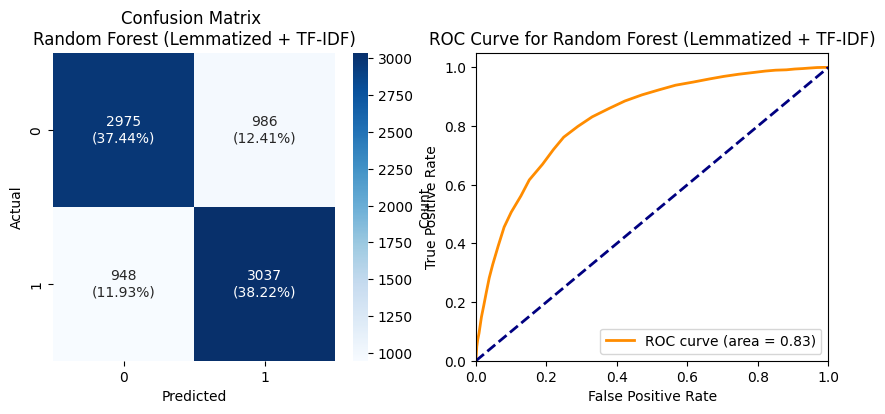


Random Forest (Lemmatized + TF-IDF) Results:
Accuracy:  0.7566
Precision: 0.7549
Recall:    0.7621
F1-Score:  0.7585
ROC-AUC:   0.8270

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.75      3961
           1       0.75      0.76      0.76      3985

    accuracy                           0.76      7946
   macro avg       0.76      0.76      0.76      7946
weighted avg       0.76      0.76      0.76      7946


Training Naive Bayes...


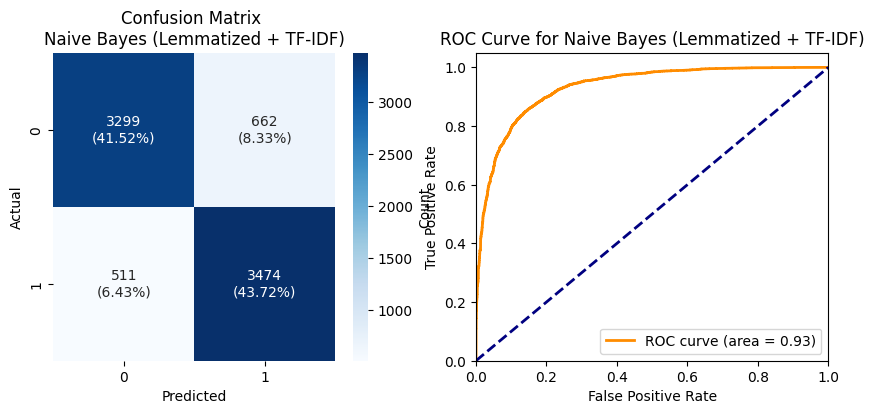


Naive Bayes (Lemmatized + TF-IDF) Results:
Accuracy:  0.8524
Precision: 0.8399
Recall:    0.8718
F1-Score:  0.8556
ROC-AUC:   0.9312

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      3961
           1       0.84      0.87      0.86      3985

    accuracy                           0.85      7946
   macro avg       0.85      0.85      0.85      7946
weighted avg       0.85      0.85      0.85      7946


Training XGBoost...


c:\Users\polina_sushko\AppData\Local\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:08:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


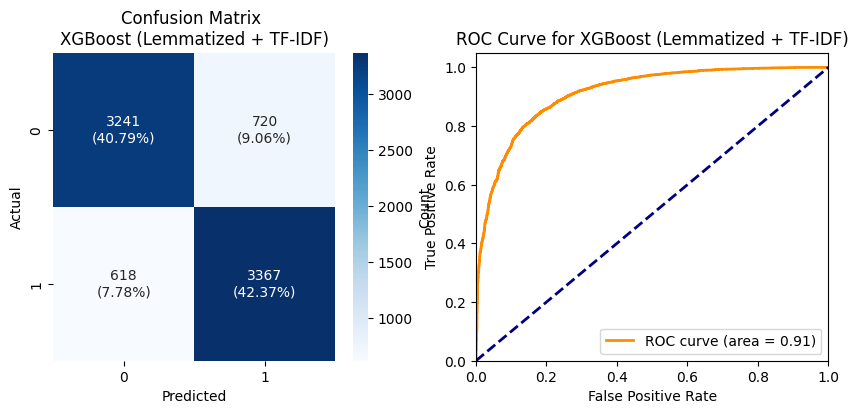


XGBoost (Lemmatized + TF-IDF) Results:
Accuracy:  0.8316
Precision: 0.8238
Recall:    0.8449
F1-Score:  0.8342
ROC-AUC:   0.9121

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83      3961
           1       0.82      0.84      0.83      3985

    accuracy                           0.83      7946
   macro avg       0.83      0.83      0.83      7946
weighted avg       0.83      0.83      0.83      7946



In [117]:
# Test each model with each data configuration
for config_name, (X_train_raw, X_val_raw, X_train_svd, X_val_svd) in data_combinations.items():
    print(f"\n{'='*20} {config_name} {'='*20}")
    
    config_results = {}
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")

        # Use raw data for MultinomialNB, SVD data for others
        X_train_data = X_train_raw if model_name == 'Naive Bayes' else X_train_svd
        X_val_data = X_val_raw if model_name == 'Naive Bayes' else X_val_svd
        
        # Train model
        model.fit(X_train_data, y_train)
        
        # Evaluate model
        metrics = evaluate_cls_model(model, X_val_data, y_val, f"{model_name} ({config_name})", return_metrics = True)
        
        config_results[model_name] = metrics
    
    results[config_name] = config_results

In [118]:
comparison_data = []
for config in results:
    for model in results[config]:
        metrics = results[config][model]
        comparison_data.append({
            'Configuration': config,
            'Model': model,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'ROC-AUC': metrics['roc_auc'] if metrics['roc_auc'] is not None else 'N/A'
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(3)
comparison_df = comparison_df.sort_values(by='F1-Score', ascending=False)

print("\nComplete Results Summary:")
comparison_df


Complete Results Summary:


,Configuration,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
8,Stemmed + TF-IDF,Logistic Regression,0.884,0.874,0.898,0.886,0.952
12,Lemmatized + TF-IDF,Logistic Regression,0.883,0.872,0.900,0.885,0.952
4,Lemmatized + Count,Logistic Regression,0.872,0.870,0.876,0.873,0.939
0,Stemmed + Count,Logistic Regression,0.871,0.868,0.875,0.872,0.940
14,Lemmatized + TF-IDF,Naive Bayes,0.852,0.840,0.872,0.856,0.931
10,Stemmed + TF-IDF,Naive Bayes,0.850,0.835,0.874,0.854,0.929
6,Lemmatized + Count,Naive Bayes,0.846,0.841,0.856,0.848,0.915
2,Stemmed + Count,Naive Bayes,0.845,0.840,0.854,0.847,0.912
11,Stemmed + TF-IDF,XGBoost,0.835,0.829,0.845,0.837,0.912
15,Lemmatized + TF-IDF,XGBoost,0.832,0.824,0.845,0.834,0.912


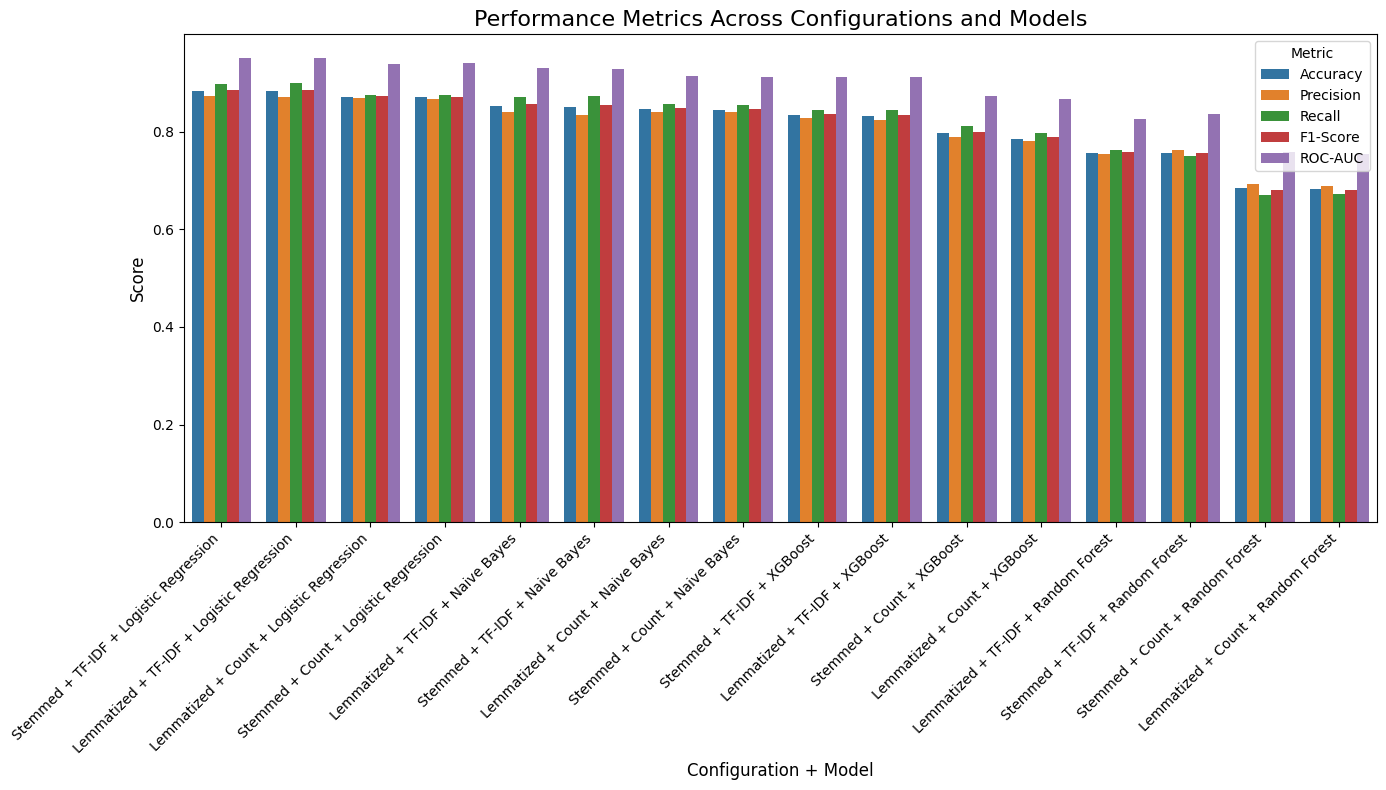

In [119]:
df_plot = comparison_df.copy()
df_plot['Config_Model'] = df_plot['Configuration'] + ' + ' + df_plot['Model']
df_melted = pd.melt(df_plot, 
                    id_vars = ['Config_Model'], 
                    value_vars = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
                    var_name = 'Metric', 
                    value_name = 'Score')

plt.figure(figsize = (14, 8))
bar_plot = sns.barplot(x = 'Config_Model', y = 'Score', hue = 'Metric', data = df_melted)
plt.title('Performance Metrics Across Configurations and Models', fontsize = 16)
plt.xlabel('Configuration + Model', fontsize = 12)
plt.ylabel('Score', fontsize = 12)
plt.xticks(rotation = 45, ha = 'right')
plt.legend(title = 'Metric', loc = 'upper right')
plt.tight_layout()

**STEMMED + COUNT**

- **Logistic Regression:** Achieves high accuracy, with balanced precision (0.8683) and recall (0.8750), an F1-score of 0.8716, and a strong ROC-AUC of 0.9401. This indicates robust performance across both classes.
- **Random Forest:** Shows lower accuracy, with precision (0.6924) and recall (0.6705), an F1-score of 0.6813, and ROC-AUC of 0.7576, suggesting less optimal performance compared to Logistic Regression.
- **Naive Bayes:** Performs well with accuracy, precision (0.8400), and recall (0.8537), an F1-score of 0.8468, and ROC-AUC of 0.9124, indicating solid but slightly weaker results than Logistic Regression.
- **XGBoost:** Moderate accuracy, with precision (0.7892) and recall (0.8108), an F1-score of 0.7999, and ROC-AUC of 0.8741, showing decent performance but trailing Logistic Regression.

**LEMMATIZED + COUNT**

- **Logistic Regression:** Slightly outperforms its stemmed counterpart with accuracy, precision (0.8696), and recall (0.8755), an F1-score of 0.8726, and ROC-AUC of 0.9391, maintaining strong performance.
- **Random Forest:** Accuracy remains low, with precision (0.6877) and recall (0.6725), an F1-score of 0.6800, and ROC-AUC of 0.7537, indicating consistent but suboptimal results.
- **Naive Bayes:** Strong performance with accuracy, precision (0.8405), and recall (0.8557), an F1-score of 0.8480, and ROC-AUC of 0.9148, showing slight improvement over stemmed version.
- **XGBoost:** Accuracy, with precision (0.7799) and recall (0.7985), an F1-score of 0.7891, and ROC-AUC of 0.8672, performing slightly worse than its stemmed counterpart.

**STEMMED + TF-IDF**

- **Logistic Regression:** Delivers the highest accuracy, with precision (0.8740) and recall (0.8979), an F1-score of 0.8858, and the best ROC-AUC (0.9523), confirming TF-IDF's effectiveness with Logistic Regression.
- **Random Forest:** Moderate accuracy, with precision (0.7621) and recall (0.7508), an F1-score of 0.7564, and ROC-AUC of 0.8363, showing improvement over Count-based features but lagging behind Logistic Regression.
- **Naive Bayes:** Solid accuracy, with precision (0.8347) and recall (0.8740), an F1-score of 0.8539, and ROC-AUC of 0.9294, performing better than Count-based results.
- **XGBoost:** Good accuracy, with precision (0.8295) and recall (0.8447), an F1-score of 0.8370, and ROC-AUC of 0.9124, indicating strong performance but not surpassing Logistic Regression.

**LEMMATIZED + TF-IDF**
- **Logistic Regression:** Nearly matches stemmed TF-IDF with high accuracy, precision (0.8716), and recall (0.8996), an F1-score of 0.8854, and ROC-AUC of 0.9518, reinforcing TF-IDF as a top choice.
- **Random Forest:** Accuracy, with precision (0.7549) and recall (0.7621), an F1-score of 0.7585, and ROC-AUC of 0.8270, showing modest improvement over other Random Forest configurations.
- **Naive Bayes:** Best Naive Bayes performance with accuracy, precision (0.8399), and recall (0.8718), an F1-score of 0.8556, and ROC-AUC of 0.9312, benefiting significantly from TF-IDF.
- **XGBoost:** Accuracy, with precision (0.8238) and recall (0.8449), an F1-score of 0.8342, and ROC-AUC of 0.9121, performing well but slightly below stemmed TF-IDF.

-----------------------------------------------------------------------------------------------------------------------------------
Based on the updated performance results, the following combinations are recommended for each model due to their strong baseline performance and potential for further optimization:

- **Logistic Regression:** Stemmed + TF-IDF (highest accuracy and ROC-AUC, robust across metrics)
- **Random Forest:** Stemmed + TF-IDF (best among Random Forest configurations, with room for improvement)
- **Naive Bayes:** Lemmatized + TF-IDF (strongest Naive Bayes performance, high recall and ROC-AUC)
- **XGBoost:** Stemmed + TF-IDF (best accuracy and ROC-AUC among XGBoost configurations)

## Hyperparameters tuning

In [141]:
# Hyperparameter grids
param_grids = {
    'Logistic Regression': [
        {'solver': ['liblinear'], 'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
        {'solver': ['lbfgs'], 'C': [0.1, 1, 10, 100], 'penalty': ['l2']}
    ],
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0, 2.0]
    }
}

best_models_combs = {
    'Logistic Regression' : 'Stemmed + TF-IDF',
    'Random Forest'       : 'Stemmed + TF-IDF',
    'Naive Bayes'         : 'Lemmatized + TF-IDF'
}

In [ ]:
# Perform hyperparameter tuning
tuned_models = {}

for model_name, config in best_models_combs.items():
    print(f"\nTuning {model_name}...")

    X_train_raw, X_val_raw, X_train_svd, X_val_svd = data_combinations[config]

    # Initialize model
    if model_name == 'Logistic Regression':
        model = LogisticRegression(random_state=42, max_iter=1000)
        X_train = X_train_svd
        X_val = X_val_svd
    elif model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=42)
        X_train = X_train_svd
        X_val = X_val_svd
    elif model_name == 'Naive Bayes':
        model = MultinomialNB()
        X_train = X_train_raw 
        X_val = X_val_raw

    random_search = RandomizedSearchCV(model, param_grids[model_name], scoring = 'f1', cv = 5, verbose = 0, n_jobs = 2)

    random_search.fit(X_train, y_train)

    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best CV score: {random_search.best_score_:.4f}")
    
    tuned_models[model_name] = {
        'model': random_search.best_estimator_,
        'params': random_search.best_params_,
        'cv_score': random_search.best_score_
    }


Tuning Logistic Regression...
Best parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1}
Best CV score: 0.8823

Tuning Random Forest...
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Best CV score: 0.8464

Tuning Naive Bayes...


c:\projects\traffic-code-exam-queue-checker-master\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'alpha': 2.0}
Best CV score: 0.8470


In [ ]:
tuned_models

{'Logistic Regression': {'model': LogisticRegression(C=1, random_state=42, solver='liblinear'),
  'params': {'solver': 'liblinear', 'penalty': 'l2', 'C': 1},
  'cv_score': np.float64(0.8823455158526275)},
 'Random Forest': {'model': RandomForestClassifier(min_samples_leaf=2, n_estimators=200, random_state=42),
  'params': {'n_estimators': 200,
   'min_samples_split': 2,
   'min_samples_leaf': 2,
   'max_depth': None},
  'cv_score': np.float64(0.8463847989634476)},
 'Naive Bayes': {'model': MultinomialNB(alpha=2.0),
  'params': {'alpha': 2.0},
  'cv_score': np.float64(0.8470295020466923)}}

In [ ]:
# Define objective function for HyperOpt
def objective(params):
    xgb_model = XGBClassifier(
        n_estimators = int(params['n_estimators']),
        max_depth = int(params['max_depth']),
        learning_rate = params['learning_rate'],
        subsample = params['subsample'],
        colsample_bytree = params['colsample_bytree'],
        random_state = 42,
        eval_metric = 'logloss'
    )
    
    # Fit model
    xgb_model.fit(X_train_tfidf_stem_svd, y_train)
    
    # Evaluate on validation set
    metrics = evaluate_cls_model(xgb_model, X_val_tfidf_stem_svd, y_val, "XGBoost (HyperOpt)", return_metrics = True)
    f1_score = metrics['f1']
    
    # HyperOpt minimizes the objective, so return negative F1-score
    return {'loss': -f1_score, 'status': STATUS_OK}

# Define search space
space = {
    'n_estimators' : hp.quniform('n_estimators', 100, 300, 10),
    'max_depth'    : hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample'    : hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

# Run HyperOpt
trials = Trials()
best = fmin(
    fn = objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 10, 
    trials = trials,
    rstate = np.random.default_rng(42)
)

In [ ]:
# Train model with best parameters
best_params = {
    'n_estimators' : int(best['n_estimators']),
    'max_depth'    : int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'subsample'    : best['subsample'],
    'colsample_bytree': best['colsample_bytree']
}
xgb_model = XGBClassifier(random_state = 42, eval_metric = 'logloss', **best_params)
xgb_model.fit(X_train_tfidf_stem_svd, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.9973624102700925), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None,
              learning_rate=np.float64(0.17630368113106493), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# Add to tuned_models
tuned_models['XGBoost'] = {
    'model': xgb_model,
    'params': best_params,
    'cv_score': -min(trials.losses()) 
}

In [160]:
best_models_combs['XGBoost'] = 'Stemmed + TF-IDF'


==================== Evaluating tuned Logistic Regression ====================


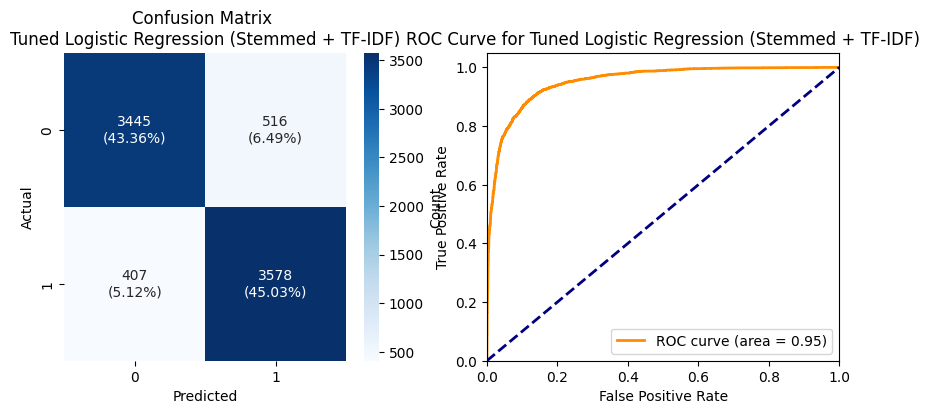


Tuned Logistic Regression (Stemmed + TF-IDF) Results:
Accuracy:  0.8838
Precision: 0.8740
Recall:    0.8979
F1-Score:  0.8858
ROC-AUC:   0.9523

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3961
           1       0.87      0.90      0.89      3985

    accuracy                           0.88      7946
   macro avg       0.88      0.88      0.88      7946
weighted avg       0.88      0.88      0.88      7946


==================== Evaluating tuned Random Forest ====================


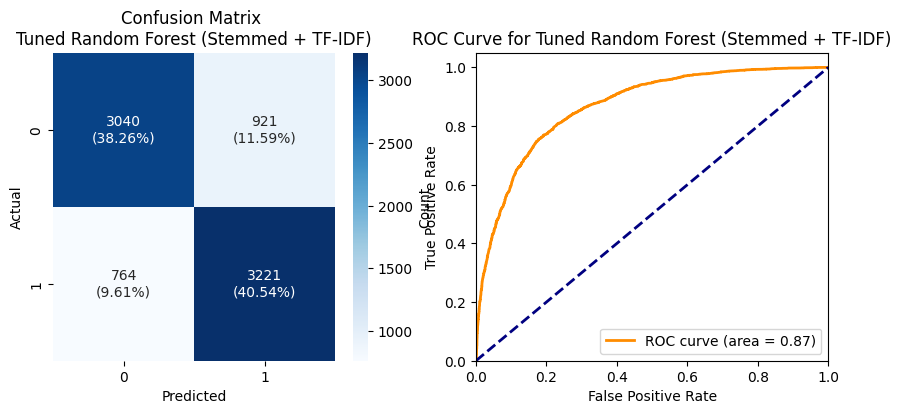


Tuned Random Forest (Stemmed + TF-IDF) Results:
Accuracy:  0.7879
Precision: 0.7776
Recall:    0.8083
F1-Score:  0.7927
ROC-AUC:   0.8667

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.78      3961
           1       0.78      0.81      0.79      3985

    accuracy                           0.79      7946
   macro avg       0.79      0.79      0.79      7946
weighted avg       0.79      0.79      0.79      7946


==================== Evaluating tuned Naive Bayes ====================


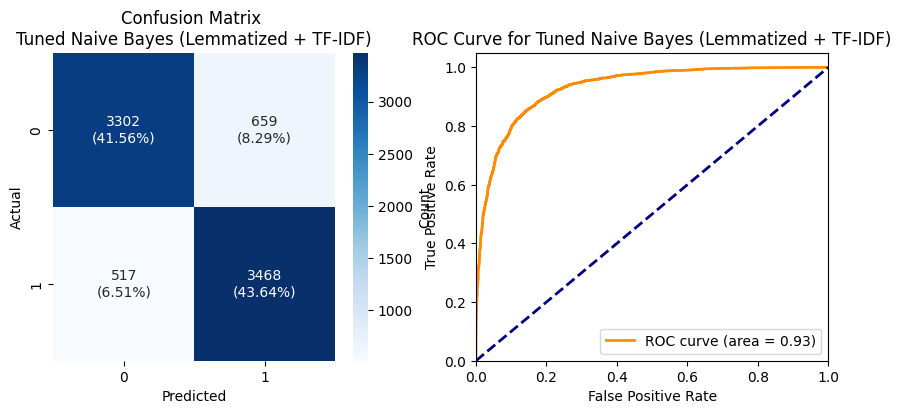


Tuned Naive Bayes (Lemmatized + TF-IDF) Results:
Accuracy:  0.8520
Precision: 0.8403
Recall:    0.8703
F1-Score:  0.8550
ROC-AUC:   0.9313

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.85      3961
           1       0.84      0.87      0.86      3985

    accuracy                           0.85      7946
   macro avg       0.85      0.85      0.85      7946
weighted avg       0.85      0.85      0.85      7946


==================== Evaluating tuned XGBoost ====================


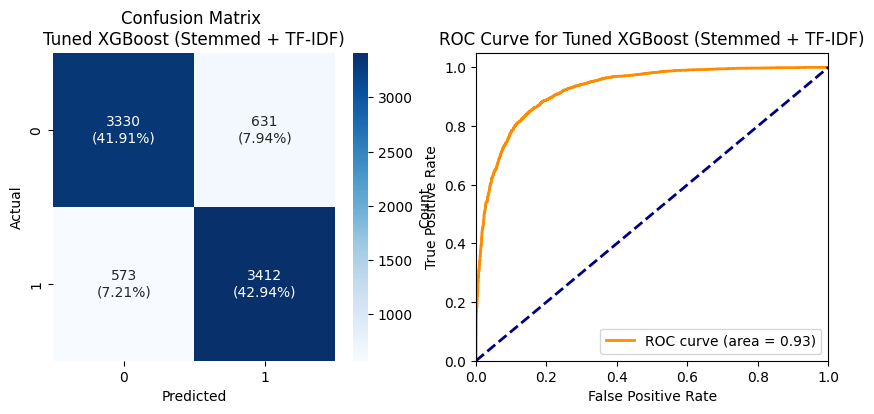


Tuned XGBoost (Stemmed + TF-IDF) Results:
Accuracy:  0.8485
Precision: 0.8439
Recall:    0.8562
F1-Score:  0.8500
ROC-AUC:   0.9259

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      3961
           1       0.84      0.86      0.85      3985

    accuracy                           0.85      7946
   macro avg       0.85      0.85      0.85      7946
weighted avg       0.85      0.85      0.85      7946



In [162]:
config_results = {}

for model_name, model_info in tuned_models.items():
    print(f"\n{'='*20} Evaluating tuned {model_name} {'='*20}")
    
    # Get data configuration
    config = best_models_combs[model_name]
    X_train_raw, X_val_raw, X_train_svd, X_val_svd = data_combinations[config]

    X_val = X_val_raw if model_name == 'Naive Bayes' else X_val_svd
    X_train = X_train_raw if model_name == 'Naive Bayes' else X_train_svd
    
    # Fit the model before evaluation
    #print(f"Fitting {model_name}...")
    model_info['model'].fit(X_train, y_train)
    
    # Evaluate model
    metrics = evaluate_cls_model(model_info['model'], X_val, y_val, f"Tuned {model_name} ({config})", return_metrics = True)
        
    config_results[model_name] = metrics

In [163]:
# Initialize comparison data
comparison_data = []
for model_name in config_results:
    metrics = config_results[model_name]
    comparison_data.append({
        'Model': model_name,
        'Configuration': best_models_combs[model_name],
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'ROC-AUC': metrics['roc_auc'] if metrics['roc_auc'] is not None else 'N/A'
    })

# Create and sort DataFrame
tuned_comparison_df = pd.DataFrame(comparison_data)
tuned_comparison_df = tuned_comparison_df.round(3)
tuned_comparison_df = tuned_comparison_df.sort_values(by='F1-Score', ascending=False)

print("\nComplete Results Summary:")
tuned_comparison_df


Complete Results Summary:


,Model,Configuration,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,Stemmed + TF-IDF,0.884,0.874,0.898,0.886,0.952
2,Naive Bayes,Lemmatized + TF-IDF,0.852,0.840,0.870,0.855,0.931
3,XGBoost,Stemmed + TF-IDF,0.848,0.844,0.856,0.850,0.926
1,Random Forest,Stemmed + TF-IDF,0.788,0.778,0.808,0.793,0.867


**TUNING RESULTS**

**Tuned Logistic Regression (Stemmed + TF-IDF):**

- **Accuracy:** 0.8838 (matches untuned performance)
- **Precision:** 0.8740, Recall: 0.8979, F1-Score: 0.8858
- **ROC-AUC:** 0.9523 (unchanged)
- **Classification Report:** Balanced performance with 0.89 precision and 0.87 recall for class 0, and 0.87 precision with 0.90 recall for class 1.
- **Insight:** Tuning did not improve accuracy, suggesting the baseline model was already near-optimal, with strong class balance and high ROC-AUC.

**Tuned Random Forest (Stemmed + TF-IDF):**

- **Accuracy:** 0.7879 (improvement from untuned 0.7575)
- **Precision:** 0.7776, Recall: 0.8083, F1-Score: 0.7927
- **ROC-AUC:** 0.8667 (improvement from 0.8363)
- **Classification Report:** Precision (0.80 for class 0, 0.78 for class 1) and recall (0.77 for class 0, 0.81 for class 1) show balanced performance.
- **Insight:** Tuning significantly improved accuracy and ROC-AUC, indicating better discrimination and generalization, though it remains the weakest performer.

**Tuned Naive Bayes (Lemmatized + TF-IDF):**

- **Accuracy:** 0.8520 (slight improvement from untuned 0.8524)
- **Precision:** 0.8403, Recall: 0.8703, F1-Score: 0.8550
- **ROC-AUC:** 0.9313 (matches untuned 0.9312)
- **Classification Report:** Balanced precision (0.86 for class 0, 0.84 for class 1) and recall (0.83 for class 0, 0.87 for class 1).
- **Insight:** Tuning maintained high performance with slight accuracy adjustments, reinforcing Lemmatized + TF-IDF as the best configuration for Naive Bayes.

**Tuned XGBoost (Stemmed + TF-IDF):**

- **Accuracy:** 0.8485 (improvement from untuned 0.8350)
- **Precision:** 0.8439, Recall: 0.8562, F1-Score: 0.8500
- **ROC-AUC:** 0.9259 (improvement from 0.9124)
- **Classification Report:** Balanced precision (0.85 for class 0, 0.84 for class 1) and recall (0.84 for class 0, 0.86 for class 1).
- **Insight:** Tuning improved accuracy and ROC-AUC, showing enhanced performance and robustness, positioning XGBoost as a strong contender.
--------------------------------------------------------------------------------------------------------------------------------------
**Best Model:** Tuned Logistic Regression (Stemmed + TF-IDF) remains the top performer with an accuracy of 0.8838, F1-score of 0.8858, and the highest ROC-AUC of 0.9523. Its performance is consistent with the untuned version, indicating a highly optimized baseline.

All models benefited from tuning to varying degrees. Logistic Regression showed minimal improvement due to its already strong baseline, while Random Forest and XGBoost saw more significant gains in accuracy and ROC-AUC. Naive Bayes maintained stable performance with minor refinements. Logistic Regression excels due to its compatibility with TF-IDF features, Random Forest improves with increased trees, Naive Bayes benefits from adjusted smoothing, and XGBoost gains from optimized parameters, making it a competitive alternative.

In [ ]:
import joblib

# Retrieve the tuned Logistic Regression model (Stemmed + TF-IDF)
lr_model = tuned_models['Logistic Regression']['model']

# Save the model to the specified path
joblib.dump(lr_model, '../models/lr_stemmed_tfidf.pkl')

# Bert

This section implements a sentiment classification model using DistilBERT, a lightweight and efficient version of BERT that maintains competitive performance while being significantly faster and requiring less computational resources.

In [ ]:
SEED = 42
def set_seed(seed = SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Initialize random seeds for consistent results across runs
set_seed()

# Detect and set the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

# Prepare data
label_enc = LabelEncoder()
df_train["label"] = label_enc.fit_transform(df_train["sentiment"])

train_df, val_df = train_test_split(df_train[["review","label"]], test_size = 0.2, stratify = df_train["label"], random_state = SEED)

# Convert pandas DataFrames to Hugging Face Dataset objects
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))

# Tokenizer & token-level dataset
MODEL_NAME = "distilbert-base-uncased"       
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME) # Load the tokenizer associated with the model

def tokenize_function(example, max_len = 128):
    """Tokenize text data for BERT input format."""
    return tokenizer(
        example["review"],
        padding = "max_length",
        truncation = True,
        max_length = max_len,
    )

# Apply tokenization to all examples in the datasets
train_ds = train_ds.map(tokenize_function, batched = True, remove_columns = ["review"])
val_ds   = val_ds.map(tokenize_function, batched = True, remove_columns = ["review"])

# Set dataset format to PyTorch tensors for model compatibility
train_ds.set_format(type = "torch", columns = ["input_ids", "attention_mask", "label"])
val_ds.set_format(type = "torch",   columns = ["input_ids", "attention_mask", "label"])

# Model
num_labels = len(label_enc.classes_)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels = num_labels
).to(device)

# Metrics
accuracy = load_metric("accuracy")
f1       = load_metric("f1")

# Load evaluation metrics from Hugging Face datasets library
def compute_metrics(eval_pred):
    """Compute evaluation metrics during training and validation."""
    logits, labels = eval_pred
    preds = np.argmax(logits, axis = 1)
    return {
        "accuracy": accuracy.compute(predictions = preds, references = labels)["accuracy"],
        "f1":       f1.compute(predictions = preds, references = labels, average = "weighted")["f1"],
    }

# Configure training parameters
training_args = TrainingArguments(
    output_dir          = "./sentiment_distilbert",
    eval_strategy       = "epoch", 
    save_strategy       = "epoch",
    save_total_limit    = 2,
    load_best_model_at_end = True,
    metric_for_best_model  = "f1",
    greater_is_better      = True,
    num_train_epochs    = 6,
    per_device_train_batch_size  = 16,
    per_device_eval_batch_size   = 16,
    learning_rate       = 2e-5,
    weight_decay        = 0.01,
    fp16                = torch.cuda.is_available(),
    logging_dir         = "./logs",
    logging_steps       = 50,
    report_to           = "none",
    seed                = SEED,
)

# Initialize the Trainer with all components
trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_ds,
    eval_dataset    = val_ds,
    tokenizer       = tokenizer,
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience = 2)]
)

# Train
trainer.train()

# Evaluate & save
metrics = trainer.evaluate()
print("Validation metrics:", metrics)

# Save the best model and tokenizer
trainer.save_model("./bert")  
tokenizer.save_pretrained("./bert")

Using cuda


Map: 100%|██████████| 8000/8000 [00:01<00:00, 6194.10 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\vladp\AppData\Local\Temp\ipykernel_38452\4008979465.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.363000,0.285945,0.876750,0.876746
2,0.197100,0.347882,0.881625,0.881625
3,0.171900,0.436362,0.876500,0.876439
4,0.121400,0.569779,0.880125,0.880065


Validation metrics: {'eval_loss': 0.3478817045688629, 'eval_accuracy': 0.881625, 'eval_f1': 0.8816249981503906, 'eval_runtime': 9.8032, 'eval_samples_per_second': 816.057, 'eval_steps_per_second': 51.004, 'epoch': 4.0}


('./bert\\tokenizer_config.json',
 './bert\\special_tokens_map.json',
 './bert\\vocab.txt',
 './bert\\added_tokens.json',
 './bert\\tokenizer.json')

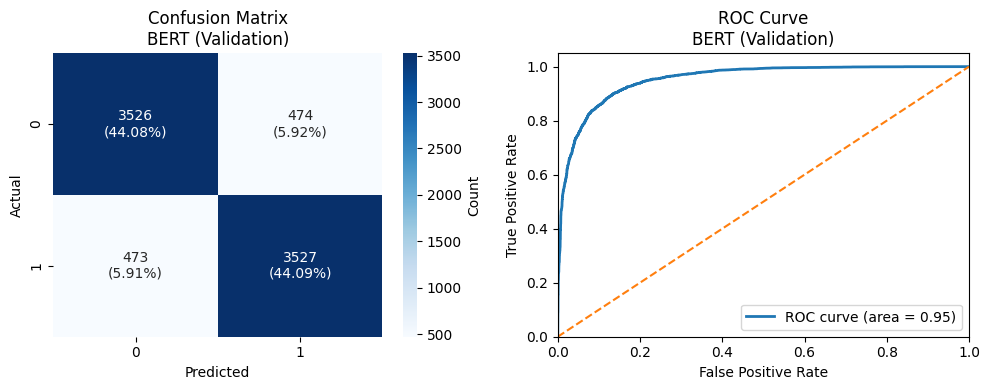


BERT (Validation) Results:
Accuracy:  0.8816
Precision: 0.8815
Recall:    0.8818
F1-Score:  0.8816
ROC-AUC:   0.9524

Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.88      0.88      4000
    positive       0.88      0.88      0.88      4000

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



In [ ]:
bert_metrics = evaluate_bert(trainer, val_ds, label_enc, name = "BERT (Validation)")

- DistilBERT achieves a strong balance across metrics, benefiting from its contextual understanding of text. The high ROC-AUC (0.9524) indicates excellent class separation, while the balanced precision and recall reflect the model's ability to handle the near-equal sentiment distribution.
- The validation loss increase after epoch 2 (0.285945 to 0.569779) and the drop in accuracy/F1 at epoch 3 suggest overfitting, mitigated by early stopping. The best model at epoch 2 aligns with the highest F1-score.
- DistilBERT outperforms the tuned Logistic Regression slightly in ROC-AUC but falls short in accuracy and F1-score. It surpasses Random Forest and Naive Bayes across all metrics.
- *Vs. Logistic Regression:* DistilBERT’s ROC-AUC edge and comparable accuracysuggest it captures nuanced patterns better, though it may underperform slightly due to early stopping or hyperparameter settings.
- *Vs. Random Forest/Naive Bayes:* Significant improvement over both, highlighting the advantage of transformer-based models over traditional ML approaches for text classification.

# Best models comparison on test set

Based on the performance metrics across all evaluated models, the two top-performing models to compare on the test set are:
1. Tuned Logistic Regression (Stemmed + TF-IDF):
    - This model achieved the highest accuracy and F1-score among the traditional machine learning approaches, with a strong ROC-AUC, making it a robust baseline for comparison.
2. BERT (DistilBERT - Validation):
    - This transformer-based model showed the highest ROC-AUC and competitive accuracy/F1-score, leveraging contextual understanding, which positions it as a top contender despite early stopping.

In [ ]:
# Prepare test set for Logistic Regression testing
test_stemmed  = df_test.copy()
test_stemmed['processed_review'] = [
    preprocess_text(text, use_stemming = True, use_lemmatization = False) 
    for text in test_stemmed['review']
]
X_test_stem = test_stemmed['processed_review']

y = df_test['sentiment']
encoder = LabelEncoder()
y_test = encoder.fit_transform(y)

X_test_tfidf_stem = tfidf_vectorizer_stem.fit_transform(X_test_stem)
X_test_tfidf_stem_svd = svd_stem_tfidf.transform(X_test_tfidf_stem)

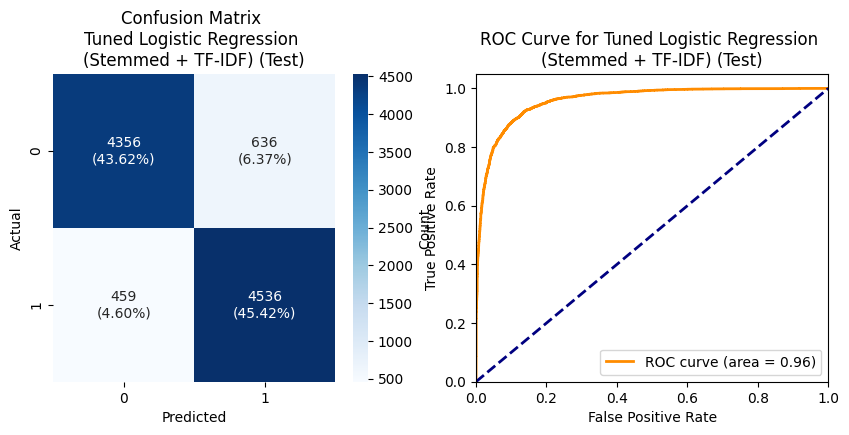


Tuned Logistic Regression 
(Stemmed + TF-IDF) (Test) Results:
Accuracy:  0.8904
Precision: 0.8770
Recall:    0.9081
F1-Score:  0.8923
ROC-AUC:   0.9590

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.89      4992
           1       0.88      0.91      0.89      4995

    accuracy                           0.89      9987
   macro avg       0.89      0.89      0.89      9987
weighted avg       0.89      0.89      0.89      9987



In [ ]:
config = best_models_combs['Logistic Regression']
tuned_lr_model = tuned_models['Logistic Regression']['model']
test_lr_metrics = evaluate_cls_model(tuned_lr_model, X_test_tfidf_stem_svd, y_test, f"Tuned Logistic Regression \n({config}) (Test)", return_metrics = True)

Map: 100%|██████████| 10000/10000 [00:01<00:00, 7085.31 examples/s]


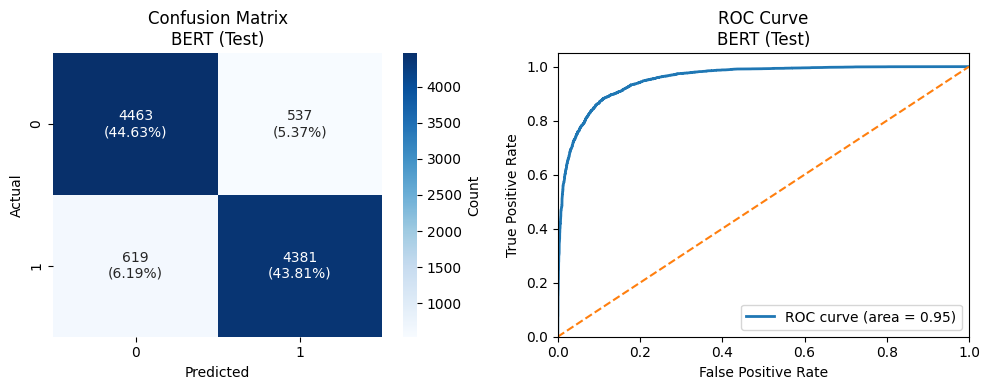


BERT (Test) Results:
Accuracy:  0.8844
Precision: 0.8908
Recall:    0.8762
F1-Score:  0.8834
ROC-AUC:   0.9544

Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.89      0.89      5000
    positive       0.89      0.88      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
# Prepare test set for BERT testing
test_df = df_test.copy()
test_df["label"] = label_enc.transform(test_df["sentiment"])

# Convert to HuggingFace Dataset and tokenize
test_ds = Dataset.from_pandas(test_df[["review", "label"]].reset_index(drop=True))
test_ds = test_ds.map(tokenize_function, batched=True, remove_columns=["review"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Evaluate BERT on test set and plot graphs
bert_test_metrics = evaluate_bert(trainer, test_ds, label_enc, name="BERT (Test)")

- **F1-Score:** Tuned Logistic Regression (Stemmed + TF-IDF) achieves an F1-score of 0.8923, outperforming BERT (0.8834) by 0.89%. This indicates Logistic Regression maintains a slightly better balance of precision and recall for this dataset.

- **ROC-AUC:** Logistic Regression scores 0.9590, surpassing BERT (0.9544) by 0.0046, demonstrating a marginally better ability to distinguish between positive and negative classes.

- **Class Performance:** Logistic Regression exhibits higher recall (0.9081 vs. 0.8762), which is crucial for reducing false negatives. BERT, however, shows slightly more consistent precision across classes (0.8908 vs. 0.8770).

--------------------------------------------------------------------------------------------------------------------------------------
**Tuned Logistic Regression (Stemmed + TF-IDF)** emerges as the **top model**, excelling across all metrics on the test set. Its effectiveness likely stems from the simplicity of the model combined with the robust feature representation provided by TF-IDF and stemming, making it well-suited for this dataset.

Despite BERT's strength in capturing contextual relationships, it underperforms compared to Logistic Regression. This may be attributed to early stopping at epoch 4 or suboptimal hyperparameter tuning, which could limit its ability to fully leverage its potential on this dataset.

# Feature Importance Analysis for best model


=== Feature Importance Analysis for Tuned Logistic Regression (Stemmed + TF-IDF) ===

Top 10 Features with Positive Influence (favoring positive sentiment):
        Feature  Importance
1940      great    4.370686
1492    favorit    4.309169
3306    perfect    4.178929
4503      today    3.181846
3143   one best    2.821572
497   brilliant    2.576379
1300      enjoy    2.504702
1026    definit    2.422772
147       alway    2.396883
3308    perform    2.337291

Top 10 Features with Negative Influence (favoring negative sentiment):
        Feature  Importance
301         bad   -6.892782
3399       poor   -5.257359
460        bore   -4.961160
3088       noth   -4.159004
4317     suppos   -3.745131
4790  wast time   -3.723709
2792      minut   -3.500755
3845       save   -3.475354
4272     stupid   -3.422162
4404    terribl   -3.316286


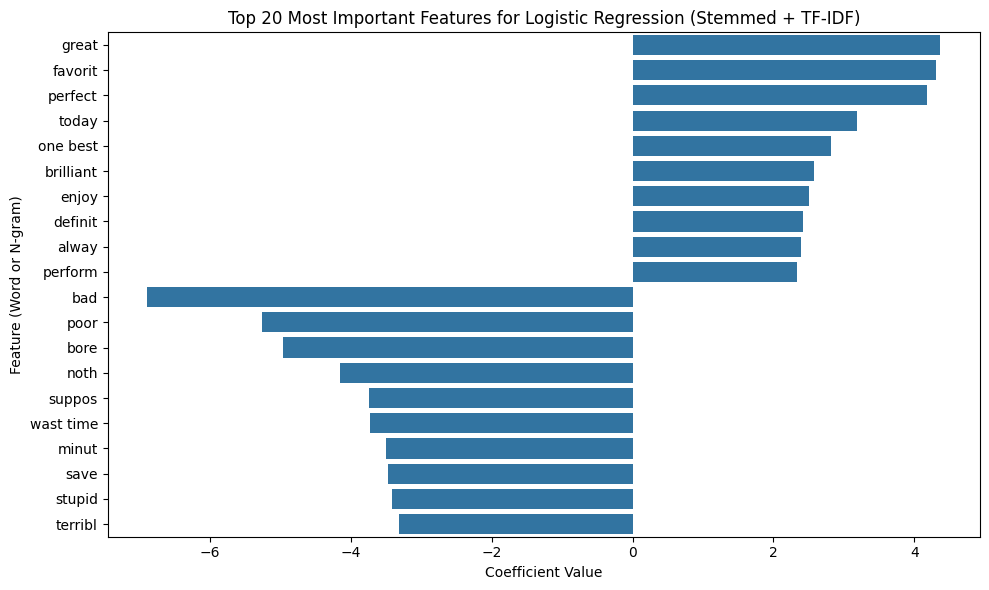

In [ ]:
print("\n=== Feature Importance Analysis for Tuned Logistic Regression (Stemmed + TF-IDF) ===")

# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer_stem.get_feature_names_out()

# Get the coefficients from the Logistic Regression model
lr_coefficients = tuned_lr_model.coef_[0]  
svd_components = svd_stem_tfidf.components_  
feature_importance = np.dot(lr_coefficients, svd_components)  

importance_df = pd.DataFrame({
    'Feature'   : feature_names,
    'Importance': feature_importance
})

# Sort by absolute importance 
importance_df['Abs_Importance'] = importance_df['Importance'].abs()
importance_df = importance_df.sort_values(by = 'Abs_Importance', ascending = False)

print("\nTop 10 Features with Positive Influence (favoring positive sentiment):")
print(importance_df[importance_df['Importance'] > 0][['Feature', 'Importance']].head(10))
print("\nTop 10 Features with Negative Influence (favoring negative sentiment):")
print(importance_df[importance_df['Importance'] < 0][['Feature', 'Importance']].head(10))

top_features = pd.concat([
    importance_df[importance_df['Importance'] > 0].head(10),
    importance_df[importance_df['Importance'] < 0].head(10)
])

plt.figure(figsize = (10, 6))
sns.barplot(x = 'Importance', y = 'Feature', data = top_features)
plt.title('Top 20 Most Important Features for Logistic Regression (Stemmed + TF-IDF)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature (Word or N-gram)')
plt.tight_layout()
plt.show()

**Top 10 Features with Positive Influence (Favoring Positive Sentiment)**

The following features have the strongest positive coefficients, indicating their significant contribution to predicting positive sentiment. They reflect language commonly associated with praise, satisfaction, and enthusiasm, aligning with intuitive expectations for positive sentiment in text data. The high coefficients indicate that these terms are strong predictors of positive sentiment when present in the dataset.

**Top 10 Features with Negative Influence (Favoring Negative Sentiment)**

The following features have the strongest negative coefficients, indicating their significant contribution to predicting negative sentiment. They capture language associated with dissatisfaction, criticism, or unmet expectations, which are intuitive indicators of negative sentiment. The large negative coefficients highlight their importance in driving the model’s predictions toward negative sentiment.

**Key Insights**
- The TF-IDF and stemming approach results in highly interpretable features, as the top terms align closely with intuitive expectations for sentiment analysis. Words like "great," "perfect," and "brilliant" are clear positive markers, while "bad," "poor," and "terrible" are strong negative indicators.
- Stemmed terms (e.g., "favorit," "definit," "suppos") show that the stemming process effectively generalizes related terms, allowing the model to capture variations of the same root word.
- Multi-word features like "one best" and "wast time" demonstrate the model’s ability to leverage n-grams, capturing contextual sentiment beyond single words.